In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from math import *
import numpy as np
import copy
import threading
import time
import scipy.stats
import pandas as pd
import itertools
from itertools import chain
from collections import Counter

In [7]:
#Function that deploys the Dynamic LPWAN Network and also the qlearning agent on it to extract qtable for each snapshot of the graph
def FspatGraph(N, limit, goalNode = 0, distribution = "poisson", printGraph = True, embarkingNow = True, previousG = None, probOfMobilizing = 1.0, exploreRate = 0.5, alpha = 0.8, discount = 0.8):

  #Creating the network for the first snapshot of the network
  if embarkingNow == True :
    spatG = nx.Graph()
    points = []

    #creating the IoD nodes
    for nodes in range(N):
      points.append(nodes)

    #setting the IoD nodes positions according to poisson distribution
    global pos
    pos = dict()
    for nd in range(N):
      if nd == goalNode :
        pos[nd] = [2000,2000]
      elif distribution == "random":
        pos[nd] = [random.uniform(0,300), random.uniform(0,300)]

      elif distribution == "normal":
        Mean = 0
        SD = 100
        pos[nd] = [Mean+np.random.normal(0,1)*SD, Mean+np.random.normal(0,1)*SD]
      elif distribution == "poisson":
        xMin, xMax, yMin, yMax = 0, 4000, 0, 4000
        xDelta=xMax-xMin
        yDelta=yMax-yMin
        areaTotal=xDelta*yDelta

        lambda0=2; #intensity (ie mean density) of the Poisson process
        xx = xDelta*scipy.stats.uniform.rvs(0,1, size =1 )+xMin#x coordinates of Poisson points
        yy = yDelta*scipy.stats.uniform.rvs(0,1, size = 1) +yMin#y coordinates of Poisson points

        pos[nd] = [*xx, *yy]

      spatG.add_node(nd,pos = pos[nd])
  else:
    #taking the node positions from previous snapshot of the network
    N = previousG.number_of_nodes()
    pos = dict()

    #determining the probability of mobility of IoD devices according to probability distribution
    shift = []
    for i in range(N):
      if i != goalNode :
        shift.append(random.random())
      else :
        shift.append(2)

    shift = [p<=probOfMobilizing for p in shift]
    previousG.remove_edges_from(previousG.edges())

    #determining the random position of the IoD in future snapshot within the radio range
    for nd in range(N):
      pos[nd] = previousG.nodes[nd]['pos']
      if shift[nd] == 1:
        previousX = previousG.nodes[nd]['pos'][0]
        previousY = previousG.nodes[nd]['pos'][1]

        newX = random.uniform(previousX-limit, previousX + limit)
        while newX >= 4000 :
          newX = random.uniform(previousX-limit, previousX + limit)

        yLowLimit = -1*( ( limit**2 - (newX-previousX)**2 )**0.5) + previousY
        yHighLimit =  ( limit**2 - (newX-previousX)**2 )**0.5 + previousY
        newY = random.uniform( yLowLimit , yHighLimit )
        while newY >= 4000 :
          yLowLimit = -1*( ( limit**2 - (newX-previousX)**2 )**0.5) + previousY
          yHighLimit =  ( limit**2 - (newX-previousX)**2 )**0.5 + previousY
          newY = random.uniform( yLowLimit , yHighLimit )

        previousG.nodes[nd]['pos'] = [newX, newY]
        pos[nd] = [newX, newY]

    spatG = previousG

  dist = np.empty((N,N))

  #calculating changed distances and edge connections between the moves IoDs
  connects = []
  for u in range(dist.shape[0]):
    for v in range(dist.shape[1]):
      point1 = np.array(spatG.nodes[u]['pos'])
      point2 = np.array(spatG.nodes[v]['pos'])

      dist[u][v] = np.linalg.norm(point1-point2)
      dist[u][v] = (dist[u][v]<=limit)*dist[u][v]

      if dist[u][v] != 0:
        connects.append((u,v, dist[u][v]))

  spatG.add_weighted_edges_from(connects)


  #Displaying the snapshot of the graph
  if printGraph == True :
    fig, ax = plt.subplots(figsize=(20, 10))
    nx.draw(spatG,pos, with_labels = True, **{'node_color' : 'orange', 'node_size' : 400})

  #Deploying and extracting the Qtable of each of the snapshot of the network
  qTable = qLearnModel(spatG, goalNode, exploreRate, alpha, discount)


  #storing the qtable values in individual nodes
  for nds in range(N):
    qChunk = {}
    for nbs in spatG[nds]:
      qChunk[nbs] = qTable[nds][nbs]

    spatG.nodes[nds]['qChunk'] =  qChunk

  return spatG, pos, qTable
#################################################################### Graph Creation Ends Here ###########################################################################################

#logistic function for displaying the created networkx graph
def printGraph(gra):
  fig, ax = plt.subplots(figsize=(20, 10))
  posi = dict()
  for nds in range(gra.number_of_nodes()):
    posi[nds] = gra.nodes[nds]['pos']
  nx.draw(gra,posi, with_labels = True, **{'node_color' : 'orange', 'node_size' : 400})

#heuristic function for calculating the air-distance between two nodes in the snapshot of the network
def heuristicAirDistance(graph, node1, node2):
  airDist = np.linalg.norm(np.array(graph.nodes[node1]['pos'])-np.array(graph.nodes[node2]['pos']))
  return (airDist)

#function to initialise the reward and q-table
def rAndQs(graph, goalNode):
  n = graph.number_of_nodes()
  hW = 0.7

  #initialising the reward values for every state-action pair according to heuristic algorithm discussed in the paper
  global R
  R= np.zeros(shape = (n,n))
  for u in range(n) :
    for v in graph[u]:
      R[u][v] = (1/( hW*heuristicAirDistance(graph,v,goalNode) + (1-hW)*heuristicAirDistance(graph,u,v) ) )

  for v in graph[goalNode] :
    R[v][goalNode] = R[v][goalNode] + 100

  #Qtable initialisation
  global Q
  Q= np.zeros(shape = (n,n))
  Q -= 200
  for nds in range(n):
    for nbs in graph[nds]:
      Q[nds][nbs] = 0
      Q[nbs][nds] = 0

  return

#function to select the next state/action for a given state according to the exploration rate
def nextState(graph, startNode, exploreRate):
  #action following exploration
  if (random.random()<=exploreRate):
    sample = list(dict(graph[startNode]).keys())

  #action following exploitation
  else :
    sample = np.where(Q[startNode,] == np.max(Q[startNode,]))[0]

  nextNode = int(random.choice(sample))

  return nextNode

#function to update the Qtable for a given state-action pair
def updateQs(node1, node2, alpha, discount):
  #calculating the future discounted reward
  futureSample = np.where(Q[node2,] == np.max(Q[node2,]))[0]
  if futureSample.shape[0] > 1:
    futureNextState = int(random.choice(futureSample))
  else :
    futureNextState = int(futureSample)
  maxValue = Q[node2,futureNextState]

  #Updating the qtable according to the reinforcement learning algorithm explained in the paper
  Q[node1,node2] = ((1-alpha)*Q[node1,node2] + alpha*(R[node1,node2] + discount*maxValue))

#function that initialises and deploys the qlearning agent
def qLearnModel(graph, goalNode, exploreRate, alpha, discount):
  rAndQs(graph, goalNode)

  n = graph.number_of_nodes()

  #Training the qlearning agent for 80000 epochs
  for i in range(80000):
    start = random.randint(0,n-1)
    if len(graph[start]) >=1 :
      #setting the decaying learning rate
      alpha = alpha**(0.85 * (i//1000))
      nextNode = nextState(graph, start, exploreRate)
      updateQs(start, nextNode, alpha, discount)

  return Q

################################################################# Functions Related To Shortest Path End Here #########################################################################


In [8]:

#function to determine the shortestpath calculation
def shortestPath1(graph, QTable, sourceNode, goalNode, cords, exploreRate=0.5, alpha=0.8, discount=0.8):

  #looking up the learned qtable for each snapshot of the network
  qTable = copy.deepcopy(QTable)
  count = 0
  tolerance = 0
  #performing the shortest path search algorithm according the residual energies of the IoD devices
  if ene[sourceNode]>1:
    path = [sourceNode]
  else:
    return [], qTable

  nextNode = np.argmax(qTable[sourceNode,])
  tic = time.time()
  toc = tic

  db = round(((sqrt(((cords[sourceNode][0]-cords[nextNode][0])**2)+((cords[sourceNode][1]-cords[nextNode][1])**2) ))),2)



  startEngDeduction = 0
  while nextNode != goalNode :

    #Condition when qtable and the residual energies of the nodes both support q-learning algorithm
    if nextNode not in path and ene[nextNode] >1:

      path.append(nextNode)
      db = round(((sqrt(((cords[path[-2]][0]-cords[nextNode][0])**2)+((cords[path[-2]][1]-cords[nextNode][1])**2) ))),2)
      startEngDeduction = 1

      #deducing the energy of transmission according to distance models
      if db<=520 and startEngDeduction != 0:
          e=0.3256*pow(10,-3)+(0.000041*pow(db,2))
          ene[path[-2]]=ene[path[-2]]-e

      elif db>520 and startEngDeduction != 0:
          e=0.3256*pow(10,-3)+((2*pow(10,-10)*pow(db,4)))
          ene[path[-2]]=ene[path[-2]]-e

      nextNode = np.argmax(qTable[nextNode,])

    #Condition when qtable best node can't be used due to low residual energy, then the next best node until 3 or less attempts is tried out
    elif (nextNode in path and tolerance == 0) or (ene[nextNode] <=1 and tolerance == 0) :
      count = 0
      while count < min(4,len(graph[path[-1]])-1) :
        count += 1
        if count == 1 :
          qChunk = {}
          for nbs in graph[path[-1]]:
            qChunk[nbs] = qTable[path[-1]][nbs]
          listOfQmax = sorted(qChunk.items(), key=lambda item: item[1], reverse = True)
          listOfQmax = [t[0] for t in listOfQmax]

        #chosing the next best node with required residual energy
        if ene[listOfQmax[count]]>1:
          nextNode = listOfQmax[count]

        #if next node has energy make it the next node
        if nextNode not in path and ene[nextNode] >1 :
          break
      #if no suitable IoD is selected after 3 attempts tolerance is lost and direct hop is executed
      if count >= 4 or count >= len(graph[path[-1]])-1:
        tolerance = 1

    #condition for executing a direct hop transmission
    elif (nextNode in path and tolerance == 1) or (ene[nextNode] <=1 and tolerance == 1):
      #path.append("--Kinked path to-- ")
      db = round(((sqrt(((cords[path[-1]][0]-cords[0][0])**2)+((cords[path[-1]][1]-cords[0][1])**2) ))),2)
      if db<=520 :
          e=0.3256*pow(10,-3)+(0.000041*pow(db,2))
          ene[path[-1]]=ene[path[-1]]-e

      else:
          e=0.3256*pow(10,-3)+(2*pow(10,-10)*pow(db,4))
          ene[path[-1]]=ene[path[-1]]-e


      break


  path.append(goalNode)

  return path, qTable


#logistic function to find the best exploration rate
def shortestPathConclusion(graph, sourceNode, goalNode, alpha, discount):
  sps = []
  spls =[]
  qtables = []
  exploreRates = [0.0 + i/10 for i in range(10)]

  for exploreRate in exploreRates :
    sp, qtable= shortestPath1(graph, sourceNode, goalNode, exploreRate, alpha, exploreRate)
    sps.append(sp)
    qtables.append(qtable)
    length = 0
    for i in range(len(sp)-1):
      if type(sp[i+1]) == type("str") :
        length = float('inf')
        break
      length += graph[sp[i]][sp[i+1]]['weight']
    spls.append(length)

  print("\nAll experimented paths : ", sps)
  return sps[spls.index(min(spls))], qtables[spls.index(min(spls))]


In [10]:
Graphs = executeSimulation(400,520 , 0.4, 100)  #all the generated snapshots are stored in Graphs

<ipython-input-7-ea8655b8e2cb>:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  futureNextState = int(futureSample)


Stats :


Total duration of the simulation set :  100

Total duration of time simulation used :  102.45887446403503

Time taken per one screen shot of network :  3.4152958154678346

Total output screen shots generated :  30





Streaming output truncated to the last 5000 lines.

The shortest Path of G23 with startNode 237 is : [237, 276, 268, 363, 283, 397, 0]

The shortest Path of G23 with startNode 238 is : [238, 82, 357, 236, 0]

The shortest Path of G23 with startNode 239 is : [239, 304, 140, 93, 137, 161, 0]

The shortest Path of G23 with startNode 240 is : [240, 84, 62, 75, 334, 0]

The shortest Path of G23 with startNode 241 is : [241, 102, 79, 148, 338, 227, 0]

The shortest Path of G23 with startNode 242 is : [242, 42, 0]

The shortest Path of G23 with startNode 243 is : [243, 341, 162, 270, 334, 0]

The shortest Path of G23 with startNode 244 is : [244, 248, 396, 339, 200, 236, 0]

The shortest Path of G23 with startNode 245 is : [245, 73, 218, 0]

The shortest Path of G23 with startNode 246 is : [246, 309, 334, 0]

The shortest Path of G23 with startNode 247 is : [247, 161, 0]

The shortest Path of G23 with startNode 248 is : [248, 396, 339, 200, 236, 0]

The shortest Path of G23 with startNode 249

KeyError: 30

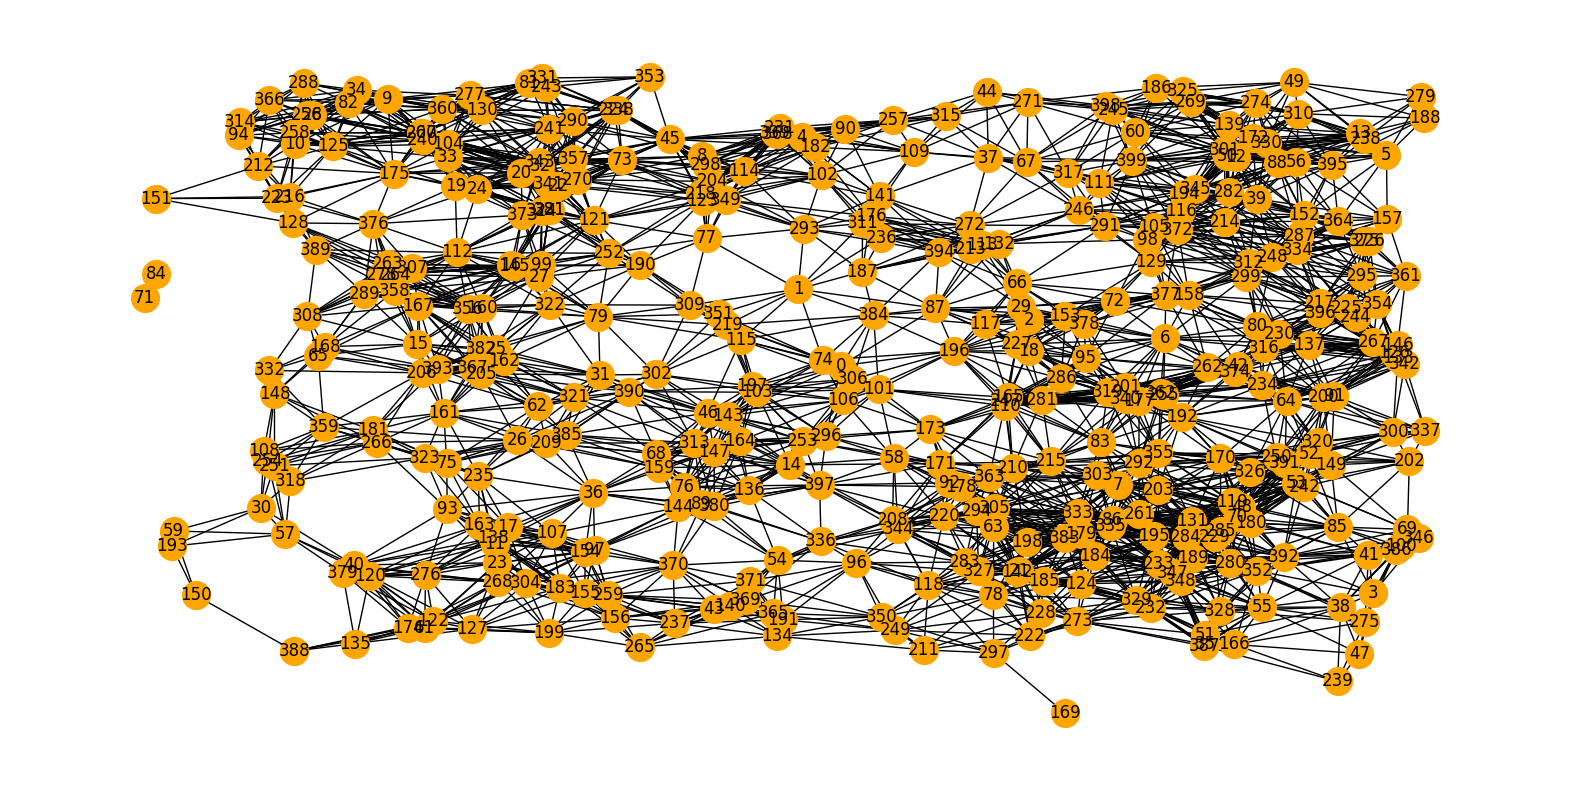

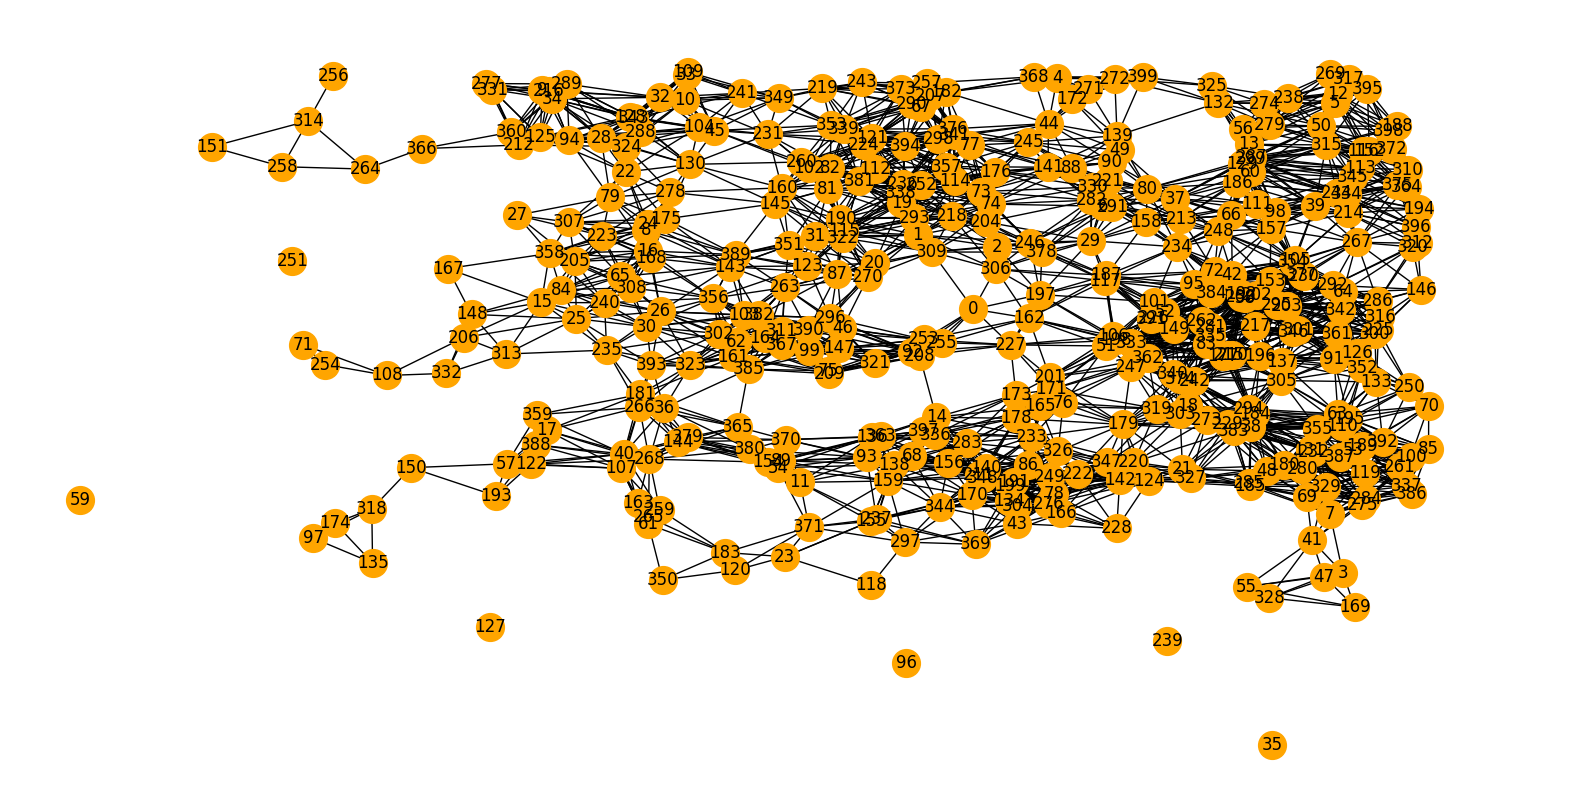

In [11]:

#function to execute the dynamic LPWAN as a whole for a totalDuration's time
def executeSimulation(NumberOfNodes, radioRange, probabilityOfMobilizing, totalDuration):
  tic = time.time()
  toc = tic
  global figCount
  figCount = 1
  listOfGraphs =[]
  while  toc-tic <= totalDuration :


    if figCount == 1:

      spatGraph,positions,qTable = FspatGraph(NumberOfNodes,radioRange, printGraph = False) #Any function


    else :

      spatGraph,positions,qTable = FspatGraph(_,radioRange, printGraph = False, embarkingNow= False, previousG= spatGraph, probOfMobilizing= probabilityOfMobilizing)

    toc = time.time()
    figCount += 1
    gra, graPos,graQt  = copy.deepcopy(spatGraph),copy.deepcopy(positions),copy.deepcopy(qTable)
    listOfGraphs.append([gra, graPos, graQt])

  print("Stats :\n")
  print("\nTotal duration of the simulation set : ", totalDuration)
  print("\nTotal duration of time simulation used : ", toc-tic)
  print("\nTime taken per one screen shot of network : ", (toc-tic)/(len(listOfGraphs)))
  print("\nTotal output screen shots generated : ", len(listOfGraphs))
  print("\n\n")

  return listOfGraphs

###################################################################### Simulation Execution Ends Here #################################################################################

#Energy of all the IoDs are initialised
enen=[]
enee=[]
for i in range(400):
  enen.append(i)
  enee.append(0)
ene=dict(zip(enen,enee))
for i in ene:
  ene[i]=72000
ene[0]=10000000
print(ene)

#shortest path implementation for all the nodes to source transmission in all the snapshots is executed and the list of shortest paths are stored
paths=[]
Gpath={}
deadn=[]
aliven=[]
enearr=[]
eeep={}
el=[]

for gphs in range(len(Graphs)):

  spath=[]
  for nds in range(400):
    if nds == 0 :
      continue
    if len(Graphs[gphs][0][nds]) >=1 :
      sp,_ = shortestPath1(Graphs[gphs][0], Graphs[gphs][2], nds, 0, Graphs[gphs][1]) # exploreRate=0.5, alpha = 0.8, discount =0.8)

      print("\nThe shortest Path of G%d with startNode %d is : %s"%(gphs,nds,sp))

      if len(sp)>1:
        paths.append(sp)
        spath.append(sp)

  Gpath[gphs]= spath
  eeep[gphs]=list(ene.values())

#Just a function call to visualise the network snapshots-02
printGraph(Graphs[1][0])

#Just a function call to visualise the network snapshots-11
printGraph(Graphs[10][0])

#logic to calculate the residual energies and dead and alive IoDs in all the snapshots of the graphs
qdeadp=[]
qalivep=[]
qresp=[]
for qq in range(200):
  qd=0
  qa=0
  EE=0
  for ww in range(400):
    if eeep[qq][ww]>0:
      qd=qd+1
      EE=EE+eeep[qq][ww]
    else:
      qa=qa+1
  qalivep.append(qd)
  qdeadp.append(qa)
  qresp.append(EE)

print("deadps=",qdeadp[-1])
print("aliveps=",qalivep[-1])
print("resps=",qresp)

#Loop showing the snapshot index and the number of dead IoDs in that particular snapshot
for i in range(0,200):
 print(i,"-------",qdeadp[i])